## CMSC 25025

## Homework 3

### Ruben Abbou

### Problem 6: Stochastic gradient descent on beer reviews

In [1]:
import re, json, numpy as np, scipy as sp, sklearn, time
import matplotlib.pyplot as plt, random
from scipy.sparse import csr_matrix
from numpy.linalg import norm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from math import exp, log

In [2]:
with open('/project2/cmsc25025/beer_review/labeled.json', 'r') as f:
    brv = json.loads(f.read())

## Part 1

In [3]:
overall_ratings = [d['overall'] for d in brv]

In [4]:
print("Mean = %f" % np.mean(overall_ratings))
print("Median = %f" % np.median(overall_ratings))
print("Standard Deviation = %f" % np.std(overall_ratings))

Mean = 13.198880
Median = 14.000000
Standard Deviation = 3.352351


In [5]:
beer_ratings = {}
brewer_ratings = {}
for item in brv:
    beer = item['beer_name']
    brewer = item['brewer']
    if beer not in beer_ratings.keys():
        beer_ratings[beer] = []
    if brewer not in brewer_ratings.keys():
        brewer_ratings[brewer] = []
    beer_ratings[beer].append(item['overall'])
    brewer_ratings[brewer].append(item['overall'])

In [6]:
beer_stats = {k: [np.mean(v), np.median(v), np.std(v)] for k, v in beer_ratings.items()}
brewer_stats = {k: [np.mean(v), np.median(v), np.std(v)] for k, v in brewer_ratings.items()}

In [7]:
pbr = beer_stats['Pabst Blue Ribbon']
print('Example with PBR: \n Mean: %.2f\n' % pbr[0], 'Median: %.2f\n' % pbr[1],
      'Standard Deviation: %.2f' % pbr[2])

Example with PBR: 
 Mean: 7.53
 Median: 7.00
 Standard Deviation: 4.67


In [8]:
b1 = brewer_stats[5731]
print('Examplew with Brewer 5731: \n Mean: %.2f\n' % b1[0], 'Median: %.2f\n' % b1[1],
      'Standard Deviation: %.2f' % b1[2])

Examplew with Brewer 5731: 
 Mean: 6.85
 Median: 6.00
 Standard Deviation: 4.55


In [9]:
beer_sd = [v[2] for v in beer_stats.values()]
brewer_sd = [v[2] for v in brewer_stats.values()]
print('Average beer rating sd: %.2f\n'%np.mean(beer_sd),
      'Average brewer rating sd: %.2f'%np.mean(brewer_sd))

Average beer rating sd: 1.33
 Average brewer rating sd: 2.09


The average standard deviations are 1.33 and 2.09, which can be considered pretty high since some beers only have one review and no standard deviation. In general, it looks like people have very different opinions about beers, which makes sense because people's tastes vary a lot.

## Part 2
### (a) *Generating features*

In [92]:
with open('/project/cmsc25025/beer_review/vocab_30.json', 'r') as f:
    vocab = json.load(f)

In [237]:
L = len(brv)
training = brv[:int(.7*L)]
validation = brv[int(.7*L):int(.85*L)]
testing = brv[int(.85*L):]
keys = list(vocab.keys())
sample = {k:0 for k in keys}

In [12]:
def make_sparse_matrix(vocab, reviews, rating_type):
    '''
    takes reviews as inputs
    returns sparse matrix of words, and labels
    '''
    keys = list(vocab.keys())
    labels = []
    words = []
    for review in reviews:
        rev = set(re.split(r'\W+', review['review'].lower()))
        rev = list(set(keys) & rev)
        if len(rev):
            words.append(rev)
            labels.append(int(review[rating_type]>=14))    
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for key in keys:
        index = vocabulary.setdefault(key, len(vocabulary))
    for rev in words:
        for term in rev:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return labels, csr_matrix((data, indices, indptr))

In [214]:
labels, words = make_sparse_matrix(vocab, training[:10000], 'overall')

In [ ]:
print(words.shape)
print(len(labels))

### (b) *Logistic regression using Newton’s method*

In [32]:
labels_val, val = make_sparse_matrix(vocab, validation[:10000], 'overall')
labels_test, test = make_sparse_matrix(vocab, testing[:10000], 'overall')

### Logistic Regression

In [33]:
lambdas = [10**float(x) for x in list(np.arange(-3, 10, 1))]
lambdas = list(np.arange(17, 23, 1))
best_lambda = 0
best_error = 1e20
for lam in lambdas:
    print(lam)
    lg = LogisticRegression(fit_intercept=True, C=1/lam, penalty='l2',
                            multi_class='multinomial', solver='newton-cg',
                            max_iter=10000)
    model = lg.fit(words, labels)
    predict = lg.predict(val)
    error = np.mean(predict!=labels_val)
    if error < best_error:
        best_lambda = lam
        best_error = error

17
18
19
20
21
22


In [42]:
print('Validation:')
print('Best lambda:', best_lambda)
print('Best error for validation: %.3f%%'% (best_error*100))

Validation:
Best lambda: 20
Best error for validation: 24.307%


In [43]:
lg = LogisticRegression(fit_intercept=True, C=1/best_lambda, penalty='l2',
                        multi_class='multinomial', solver='newton-cg',
                        max_iter=10000)
model = lg.fit(words, labels)
predict = lg.predict(test)
error = np.mean(predict!=labels_test)
print('Error for testing: %.3f%%'% (error*100))

Error for testing: 25.829%


### Hinge

In [36]:
lambdas = list(np.arange(10, 51, 1))
best_lambdah = 0
best_errorh = 1e20
for lam in lambdas:
    modelh = LinearSVC(loss='hinge', penalty='l2',
                dual=True, tol=.0001, C = 1/lam).fit(words, labels)
    predicth = modelh.predict(val)
    error = np.mean(predicth!=labels_val)
    if error < best_errorh:
        best_lambdah = lam
        best_errorh = error

In [37]:
print('Validation:')
print('Best lambda:', best_lambdah)
print('Best error: %.2f%%'% (best_errorh*100))

Validation:
Best lambda: 35
Best error: 24.19%


In [38]:
modelh = LinearSVC(loss='hinge', penalty='l2',
            dual=True, tol=.0001, C = 1/best_lambdah).fit(words, labels)
predicth = modelh.predict(test)
errorh = np.mean(predicth!=labels_test)
print('Error for testing: %.2f%%'% (errorh*100))

Error for testing: 26.41%


### (c) *Stochastic gradient descent*

#### i.

In [19]:
theta = np.zeros((len(vocab)))

#### ii.

In [13]:
def break_into_batches(data, labels, n):
    indices = [0] + [random.randint(1, data.shape[0]) for _ in range(n-1)] \
                + [data.shape[0]]
    indices = sorted(indices)
    batches = []
    batches_lab = []
    for i in range(len(indices)-1):
        m = indices[i]
        n = indices[i+1]
        batches.append(data[m:n, :])
        batches_lab.append(labels[m:n])
    return batches, batches_lab

We have:
$$ L(\theta, \lambda) = \frac{1}{2} \log \left(1+e^{-2 y \theta^Tx}\right) + \lambda \|\theta\| $$
$$ -G(y, x, \theta)=\frac{x y}{1+e^{2 y \theta^Tx}} - 2\lambda\theta $$
Therefore, our update is the following:
$$ \theta \leftarrow \theta + \delta \left(\frac{x y}{1+e^{2 y \theta^Tx}} - 2\lambda\theta\right)  $$

In [28]:
def sgd_pass_update(batch, batch_lab, theta, n, lamb, delta):
    m, n = batch.shape
    for i in range(m):
        x = batch[i]
        y = batch_lab[i]
        yhat = 1 / (1 + exp(-float(theta.dot(x))))
        grad = (y - yhat) * yhat * (1 - yhat) * x
        theta += delta*(grad - 2*lamb*theta)
    return theta

One training epoch:

In [25]:
def simulate_epoch(words, labels, theta, lam, delta, n):
    random.seed(48)
    batches, batches_lab = break_into_batches(words, labels, n)
    for i in range(n):
        if len(batches_lab[i]):
            theta = sgd_pass_update(batches[i], batches_lab[i], theta, n, lam, delta)
    return theta

#### iii.

In [29]:
def SGD(words, labels, theta, lam, delta, n, ite):
    for i in range(ite):
        theta = simulate_epoch(words, labels, theta, lam, delta, n)
    return theta

#### Cross-Validation and Testing

In [238]:
labels_train, train = make_sparse_matrix(vocab, training[:10000], 'overall')
labels_val, val = make_sparse_matrix(vocab, validation[:6000], 'overall')
labels_test, test = make_sparse_matrix(vocab, testing[:10000], 'overall')

In [239]:
number_of_batches = 80
lam = 1e-3
delta = .01
iterations = 10
theta = np.zeros((len(vocab)))
theta = SGD(train.toarray(), labels_train, theta, lam, delta, number_of_batches, iterations)

In [240]:
def get_error(theta, y, x):
    m = len(y)
    X=x
    yhats = []
    for i in range(m):
        x = X[i]
        yhats.append(1 / (1 + exp(-float(theta.dot(x)))))
    yhat_class = [int(x > 0.5) for x in yhats]
    error = []
    for i in range(len(yhat_class)):
        error.append(yhat_class[i]!=y[i])
    return np.mean(error)
print('Error rate: %.2f%%' % (get_error(theta, labels_val, val.toarray())*100))

Error rate: 29.51%


In [174]:
number_of_batches = 80
lam = 1e-3
ite = 10
errors = []
ran = [.0001, .001, .01, .1]
for delta in ran:
    thet = SGD(train.toarray()[:1000], labels_train[:1000],
               theta, lam, delta, number_of_batches, ite)
    errors.append((delta, get_error(theta, labels_test, test)))
print(errors)

After several trials, it seems like a good regularisation parameter is: $\lambda = 0.001$.

let's see the error vs. iteration plot:

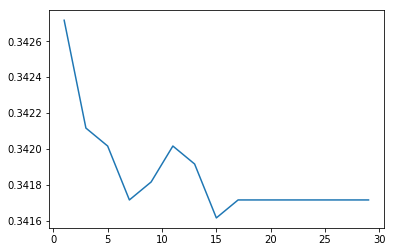

In [209]:
number_of_batches = 80
lam = 1e-3
delta = .01
errors = []
ran = range(1, 30, 2)
for ite in ran:
    thet = SGD(train.toarray()[:1000], labels_train[:1000],
               theta, lam, delta, number_of_batches, ite)
    errors.append(get_error(theta, labels_test, test))
plt.plot(ran,errors)
plt.show()

$$l(\theta | X, y)=\sum_{i=1}^{n}\left[y_{i} x_{i}^{T} \theta-\log \left(1+e^{x_{i}} \theta\right)\right]$$

It is a bit slower than logistic but still relatively fast to compute. The error rate is higher for SGD but still remains very close to logistic.

## Part 3: *Scores versus text*

In [217]:
scores = np.array([[rev['appearance'], rev['aroma'], rev['palate'],
                 rev['style'], rev['taste']] for rev in brv])
labels = 1*np.array([rev['overall']>14 for rev in brv])

In [242]:
L = len(brv)
train = scores[:int(.7*L)]
tr_labels = labels[:int(.7*L)]
validation = scores[int(.7*L):int(.85*L)]
val_labels = labels[int(.7*L):int(.85*L)]
testing = scores[int(.85*L):]
test_labels = labels[int(.85*L):]

In [219]:
lg = LogisticRegression(fit_intercept=True, C=1/lam, penalty='l2',
                        multi_class='multinomial', solver='newton-cg',
                        max_iter=10000)
model = lg.fit(scores[:100000], labels[:100000])
predict = lg.predict(validation[:10000])

In [227]:
print(np.mean([predict[i]!=(val_labels[:10000])[i] for i in range(len(predict))]))

0.1667


In [249]:
number_of_batches = 80
lam = 1e-3
delta = .01
iterations = 10
theta = np.zeros((5))
theta = SGD(train[:10000], tr_labels[:10000], theta, lam, delta, number_of_batches, iterations)

In [250]:
print('Error rate: %.2f%%' % (get_error(theta, test_labels, testing)*100))

Error rate: 39.15%


The scores model predicts better. It is very difficult to obtain a good classification with words, and it makes more sense that people rate beers higher for their characteristics if they give it a high overall rating.